# Real Estate Prediction and Streaming Analytics

DATASET DESCRIPTION
The dataset (housing_data.csv) consists of the following columns:
• Price: Target variable (House price).
• Size (sqft): Square footage of the house.
• Bedrooms: Number of bedrooms.
• Bathrooms: Number of bathrooms.
• Location_Score: Neighborhood desirability score (1-10).
• Age: Age of the house (years).

In [2]:
!pip install -q findspark

In [3]:
import findspark
findspark.init()


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark


# Phase 1 : Data Preparation and Exploration ( PySpark ) 

**Task 1: Load and explore the data**
- load dataset into a pyspark dataframe
- display summary stats and cehck for missing values
- Replace missing values with appropriate measures (mean, median, or a default)
- convert price and other numberical columns to the appropriate data type


In [30]:
#loading the dataset into a pyspark dataframe and displaying it
#sets the first row as the column headers
housing_df=spark.read.format("csv").option("header",True).load("housing_data (1).csv")

housing_df.show()

+-----------+--------+---------+--------------+---+------+
|Size (sqft)|Bedrooms|Bathrooms|Location_Score|Age| Price|
+-----------+--------+---------+--------------+---+------+
|       1360|       1|        3|             5|  2|158336|
|       4272|       1|        2|             6| 41|251463|
|       3592|       3|        2|             4| 53|203428|
|        966|       5|        2|             4| 38|100910|
|       4926|       4|        1|             4| 40|316409|
|       3944|       1|        2|             2| 48|183604|
|       3671|       4|        2|             4| 10|305304|
|       3419|       1|        2|             1| 38|175073|
|        630|       1|        3|             6| 23| 74297|
|       2185|       1|        3|             1| 59| 40815|
|       1269|       5|        1|            10| 45|114709|
|       2891|       2|        1|             6| 18|206371|
|       2933|       4|        3|             1|  3|303013|
|       1684|       5|        3|             6| 25|18157

In [31]:
# display summary stats and cehck for missing values
housing_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|       Size (sqft)|          Bedrooms|         Bathrooms|    Location_Score|               Age|            Price|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|               500|               500|               500|               500|               500|              500|
|   mean|           2805.66|              2.97|             1.986|             5.424|            28.706|       204509.928|
| stddev|1261.3562683363261|1.4523493509739835|0.8216777401251871|2.9060478709850797|17.375020768142594|95841.33687437033|
|    min|              1002|                 1|                 1|                 1|                 0|           -10754|
|    max|               999|                 5|                 3|                 9|                 9|            99583|
+-------+-------

In [32]:
from pyspark.sql.functions import *

#checking for null values, counting nulls in each colums
null_counts = housing_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in housing_df.columns])
null_counts.show()

+-----------+--------+---------+--------------+---+-----+
|Size (sqft)|Bedrooms|Bathrooms|Location_Score|Age|Price|
+-----------+--------+---------+--------------+---+-----+
|          0|       0|        0|             0|  0|    0|
+-----------+--------+---------+--------------+---+-----+



In [33]:
# convert price and other numberical columns to the appropriate data type
housing_df = housing_df.withColumn("Price", col("Price").cast("double")) \
                       .withColumn("Size (sqft)", col("Size (sqft)").cast("double")) \
                       .withColumn("Bedrooms", col("Bedrooms").cast("int")) \
                       .withColumn("Bathrooms", col("Bathrooms").cast("int")) \
                       .withColumn("Location_Score", col("Location_Score").cast("int")) \
                       .withColumn("Age", col("Age").cast("int"))

# Phase 2: Regression Analysis (House Price Prediction)
**Task 2: Train regression models**
- split data into train and test
- train a simple linear regression model using size
- train a multiple linear regression model using all features
- evaluate models using MAE MSE and RMSE
- 

In [35]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

housing_df_simple = housing_df

assembler_simple = VectorAssembler(inputCols=["Size (sqft)"], outputCol="features")
housing_df_simple = assembler_simple.transform(housing_df_simple)

train_df, test_df = housing_df_simple.randomSplit([0.8, 0.2], seed=42)

lr_simple = LinearRegression(featuresCol="features", labelCol="Price")
lr_model_simple = lr_simple.fit(train_df)

predictions_simple = lr_model_simple.transform(test_df)


In [36]:
evaluator_mae_simple = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")
evaluator_mse_simple = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mse")
evaluator_rmse_simple = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")

mae_simple = evaluator_mae_simple.evaluate(predictions_simple)
mse_simple = evaluator_mse_simple.evaluate(predictions_simple)
rmse_simple = evaluator_rmse_simple.evaluate(predictions_simple)

print(f"Simple Linear Regression Model (Size only):")
print(f"Mean Absolute Error (MAE): {mae_simple:.2f}")
print(f"Mean Squared Error (MSE): {mse_simple:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_simple:.2f}")
print()

Simple Linear Regression Model (Size only):
Mean Absolute Error (MAE): 41942.70
Mean Squared Error (MSE): 2537222031.99
Root Mean Squared Error (RMSE): 50370.85



In [37]:
housing_df_multiple = housing_df

# Assemble features for the multiple linear regression model (using all features)
assembler_all_features = VectorAssembler(inputCols=["Size (sqft)", "Bedrooms", "Bathrooms", "Location_Score", "Age"], outputCol="features_all")
housing_df_multiple = assembler_all_features.transform(housing_df_multiple)

train_df, test_df = housing_df_multiple.randomSplit([0.8, 0.2], seed=42) 

lr_all_features = LinearRegression(featuresCol="features_all", labelCol="Price")
lr_model_all_features = lr_all_features.fit(train_df)

predictions_all_features = lr_model_all_features.transform(test_df)


In [38]:
evaluator_mae_all = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")
evaluator_mse_all = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mse")
evaluator_rmse_all = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")

mae_all = evaluator_mae_all.evaluate(predictions_all_features)
mse_all = evaluator_mse_all.evaluate(predictions_all_features)
rmse_all = evaluator_rmse_all.evaluate(predictions_all_features)

print(f"Multiple Linear Regression Model (All Features):")
print(f"Mean Absolute Error (MAE): {mae_all:.2f}")
print(f"Mean Squared Error (MSE): {mse_all:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_all:.2f}")

Multiple Linear Regression Model (All Features):
Mean Absolute Error (MAE): 16291.59
Mean Squared Error (MSE): 343785518.21
Root Mean Squared Error (RMSE): 18541.45


MAE: the average magnitude of errors, so a lower value is better.  The MAE decreased in the multiple linear model, singifying that using morefeatures has helped make more accurate predictions


MSE: penalizes larger errors more than mae, a smaller mse means the model is better at predicting. The MSE is significantly lower in he multiple linear rergression indictation additional features have imporoved the models ability to fit the data

RMSE: also lower in the multiple regression model, meaning the predictions are closer to the actual house prices

# Phase 3 :Dimensionality Reduction with PCA
**Task 3: apply pca**
- reduce features to 2 principal components while retaining 95% variance
- visualize data in reduced dimensions

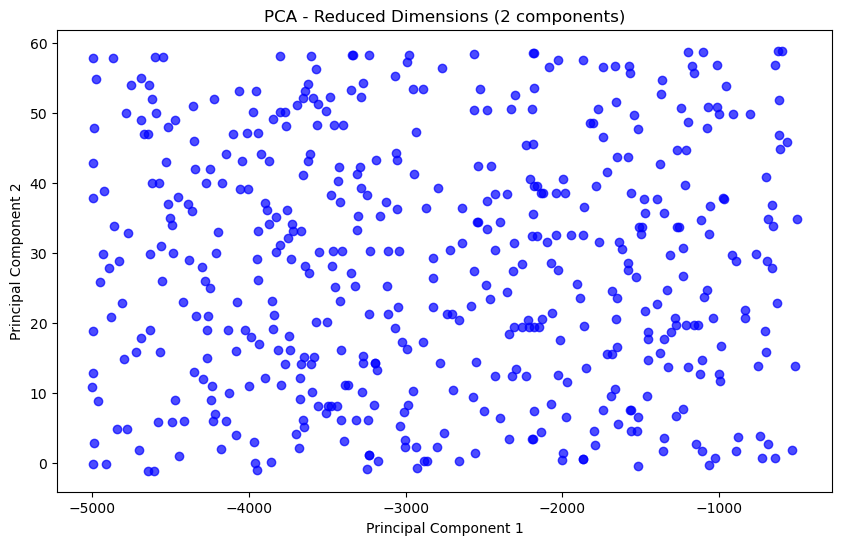

In [39]:
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

#assemble all features into a single vector
assembler_all = VectorAssembler(inputCols=["Size (sqft)", "Bedrooms", "Bathrooms", "Location_Score", "Age"], outputCol="features")
housing_df_pca = assembler_all.transform(housing_df)

#aply PCA to reduce the dimensions to 2 components
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(housing_df_pca)
housing_df_pca = pca_model.transform(housing_df_pca)

pca_result = housing_df_pca.select("pca_features").rdd.map(lambda row: row[0]).collect()

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])

plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7, c='blue')
plt.title("PCA - Reduced Dimensions (2 components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()